# General

1.   Tzur Shalom - 207107038
2.   Bar Zilbershtain - 211824883

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

In [2]:
eval_mode = False

# Auxiliary Functions

In [3]:
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10

In [4]:
def eval_model(model, data_loader, device, threshold=0.7, model_name='OSR'):

    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:

            data, labels = data.to(device), labels.to(device)

            ### Modify output if needed ###
            # data = data.view(-1, 28*28)

            # Model outputs
            outputs, _ = model(data)

            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            # Assuming the model returns an (N_batch, 11) size output
            outputs = F.softmax(outputs, dim=1)
            probas, y_pred = torch.max(outputs, 1)

            if model_name == 'OSR':
              y_pred[probas < threshold] = 10

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood if total_ood > 0 else 0
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total

In [5]:
def train_model(model, optimizer, criterion, train_loader, num_epochs=10):

  model.train()

  loss_list = []

  epoch_progress = tqdm(range(num_epochs), desc="Training Progress")

  for epoch in epoch_progress:

      running_loss = 0.0

      for images, labels in train_loader:

          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs, _ = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      loss_list.append(running_loss/len(train_loader))

  return model, loss_list

In [6]:
def evaluate_confusion_matrix(model, data_loader, device, data_type='Baseline', threshold=0.7):

    model.eval()

    all_preds = []
    all_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:

            images, labels = images.to(device), labels.to(device)

            outputs, _ = model(images)
            outputs = F.softmax(outputs, dim=1)
            probability, predicted = torch.max(outputs, 1)

            if data_type == 'OOD':
                predicted[probability < threshold] = 10
                predicted = torch.where(predicted < 10, torch.tensor(0, device=device), torch.tensor(1, device=device))
                labels = torch.where(labels < 10, torch.tensor(0, device=device), torch.tensor(1, device=device))

            if data_type == 'OSR':
                predicted[probability < threshold] = 10

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return acc, conf_matrix

In [7]:
def evaluate_dictionary(model, data_loader, device, threshold=0.7):

    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:

            images, labels = images.to(device), labels.to(device)

            outputs, _ = model(images)
            outputs = F.softmax(outputs, dim=1)
            probability, predicted = torch.max(outputs, 1)
            predicted[probability < threshold] = 10

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [8]:
def compute_roc(model, data_loader, device):

    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:

            images, labels = images.to(device), labels.to(device)

            outputs, _ = model(images)
            probability = F.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probability.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    fpr, tpr, _ = roc_curve(all_labels.ravel(), all_probs[:, 10].ravel(), pos_label=10)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [9]:
def plot_loss(loss_list, title="Training Loss"):

  plt.plot(loss_list)
  plt.grid()
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.title(title)
  plt.show()

In [10]:
def plot_tsne(embeddings, predictions):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=predictions, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(11))
    plt.title("t-SNE Visualization of Embedded Representations")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

In [11]:
def plot_pca(embeddings, predictions):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_results[:, 0], pca_results[:, 1], c=predictions, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(11))
    plt.title("PCA Visualization of Embedded Representations")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

In [12]:
def extract_embeddings(model, data_loader, device, threshold=0.7):
    model.eval()
    embeddings = []
    predictions = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs, embedding = model(images)

            outputs = F.softmax(outputs, dim=1)
            probability, predicted = torch.max(outputs, 1)
            predicted[probability < threshold] = 10

            embeddings.append(embedding.cpu().numpy())
            predictions.append(predicted.cpu().numpy())

    return np.vstack(embeddings), np.hstack(predictions)

# Data & Preprocessing

In [13]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))

transform_data_augmentation = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.RandomApply([blur_transform], p=0.3),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [40000, 20000])
train_dataset_data_augmentation = datasets.MNIST(root='./data', train=True, download=True, transform=transform_data_augmentation)
train_dataset_data_augmentation = torch.utils.data.Subset(train_dataset_data_augmentation, range(10000))
train_dataset = ConcatDataset([train_dataset, train_dataset_data_augmentation])
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

validation_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

CIFAR10_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
CIFAR10_dataset = torch.utils.data.Subset(CIFAR10_dataset, range(1000))

FashionMNIST_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
FashionMNIST_dataset = torch.utils.data.Subset(FashionMNIST_dataset, range(1000))

concatenate_dataset = ConcatDataset([CIFAR10_dataset, FashionMNIST_dataset])

combined_dataset_1 = CombinedDataset(test_dataset, concatenate_dataset)
data_loader_1 = DataLoader(combined_dataset_1, batch_size=1024, shuffle=True)

combined_dataset_2 = CombinedDataset(validation_dataset, concatenate_dataset)
data_loader_2 = DataLoader(combined_dataset_2, batch_size=1024, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.43MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170M/170M [00:05<00:00, 28.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.64MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 55.0MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 28.4MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Models

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        embedding = self.relu(self.fc1(x))
        x = self.dropout(embedding)
        x = self.fc2(x)
        return x, embedding

In [15]:
def predictor(model, image, device, threshold=0.7):

    model.eval()

    with torch.no_grad():

        image = image.unsqueeze(0)
        image = image.to(device)
        output, _ = model(image)
        output = F.softmax(output, dim=1)
        probability, predicted = torch.max(output, 1)
        predicted[probability < threshold] = 10

        if (predicted != 10):
          return predicted
        else:
          return "Unknown"

In [16]:
label_mapping = {i: i for i in range(10)}
label_mapping[10] = 'Unknown'

# Training

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

OSR_model = CNN(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(OSR_model.parameters(), lr=0.001)

if eval_mode == False:
    OSR_model, OSR_loss_list = train_model(OSR_model, optimizer, criterion, train_loader, 20)
    torch.save(OSR_model.state_dict(), './OSR_model.pth')

Training Progress: 100%|██████████| 20/20 [05:19<00:00, 15.97s/it]


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

Baseline_model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Baseline_model.parameters(), lr=0.001)

if eval_mode == False:
    Baseline_model, Baseline_loss_list = train_model(Baseline_model, optimizer, criterion, train_loader)
    torch.save(Baseline_model.state_dict(), './Baseline_model.pth')

Training Progress: 100%|██████████| 10/10 [02:40<00:00, 16.00s/it]


In [20]:
# example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

single_batch = next(iter(data_loader_1))
images, labels = single_batch
single_image = images[0]
single_label = labels[0]

single_output = predictor(OSR_model, single_image, device, 0.975)

print("Label: ", single_label)
print("Prediction: ", single_output)

Label:  tensor(9)
Prediction:  tensor([9], device='cuda:0')


In [21]:
# example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictions, labels = evaluate_dictionary(OSR_model, data_loader_1, device, 0.975)

predictions = [label_mapping[p] for p in predictions]

print("Label: ", labels[0])
print("Prediction: ", predictions[0])

Label:  7
Prediction:  7


# Evaluation - CIFAR10/Fashion-MNIST

In [ ]:
if eval_mode == True:
    OSR_model.load_state_dict(torch.load('./OSR_model.pth'))
    Baseline_model.load_state_dict(torch.load('./Baseline_model.pth'))

<ipython-input-25-f86a88a918b5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  OSR_model.load_state_dict(torch.load('./OSR_model.pth'))
<ipython-input-25-f86a88a918b5>:3: 

In [22]:
acc_mnist, acc_ood, acc_total = eval_model(OSR_model, data_loader_1, device, 0.975) # test set & CIFAR10/FashionMNIST set

print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

MNIST Accuracy: 95.35%
OOD Accuracy: 97.40%
Total Accuracy: 95.69%


In [23]:
acc_mnist, acc_ood, acc_total = eval_model(OSR_model, data_loader_2, device, 0.975) # validation set & CIFAR10/FashionMNIST set

print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

MNIST Accuracy: 95.19%
OOD Accuracy: 97.40%
Total Accuracy: 95.39%


In [24]:
acc_mnist, _, _ = eval_model(Baseline_model, test_loader, device, model_name='Baseline') # test set

print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')

MNIST Accuracy: 99.00%


In [25]:
acc_mnist, _, _ = eval_model(Baseline_model, validation_loader, device, model_name='Baseline') # validation set

print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')

MNIST Accuracy: 98.72%


Baseline model accuracy: 99.00%



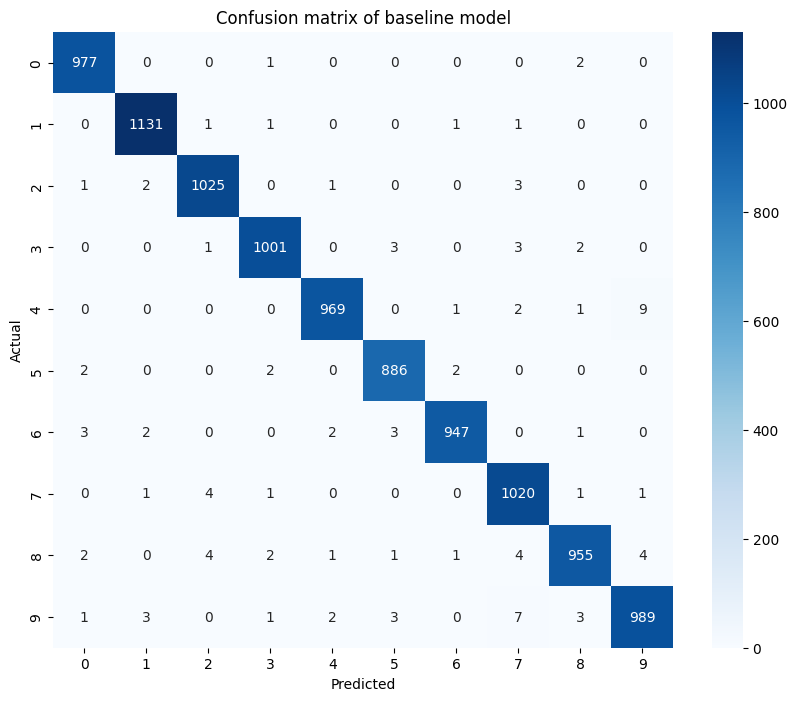

In [26]:
acc_mnist, conf_matrix = evaluate_confusion_matrix(Baseline_model, test_loader, device)
print(f'Baseline model accuracy: {acc_mnist*100:.2f}%\n')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of baseline model')
plt.show()

In [ ]:
"""
Describe your OSR approach.

Our approach is primarily based on adding a dedicated neuron to the CNN
for the "unknown" class, as well as employing data augmentation
to generate additional, more challenging examples. Furthermore,
we set a confidence threshold for each image’s label.
Specifically, if the model is less than 97.5% confident about the label
(evaluated over 20 epochs), the image is likely to be classified as "unknown."

"""

OOD classification accuracy: 95.73%



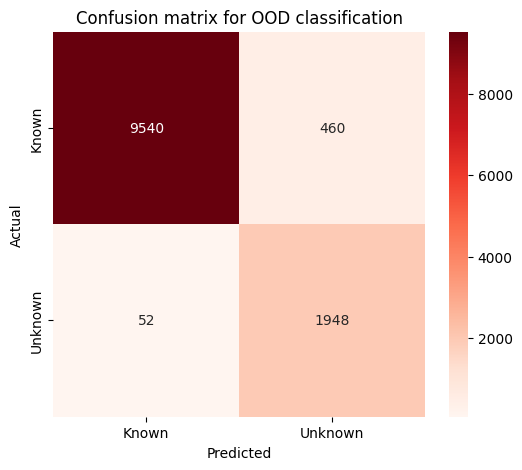

In [27]:
acc_ood, conf_matrix_ood = evaluate_confusion_matrix(OSR_model, data_loader_1, device, 'OOD', 0.975)
print(f'OOD classification accuracy: {acc_ood*100:.2f}%\n')

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ood, annot=True, fmt='d', cmap='Reds', xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for OOD classification')
plt.show()

OSR model accuracy: 95.69%



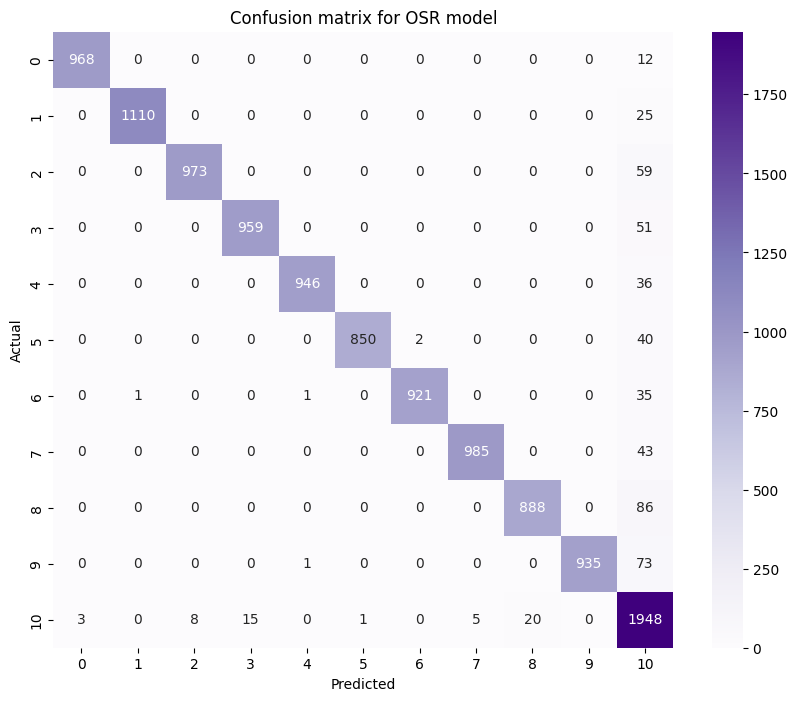

In [28]:
acc_total, conf_matrix_osr = evaluate_confusion_matrix(OSR_model, data_loader_1, device, 'OSR', 0.975)
print(f'OSR model accuracy: {acc_total*100:.2f}%\n')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_osr, annot=True, fmt='d', cmap='Purples', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for OSR model')
plt.show()

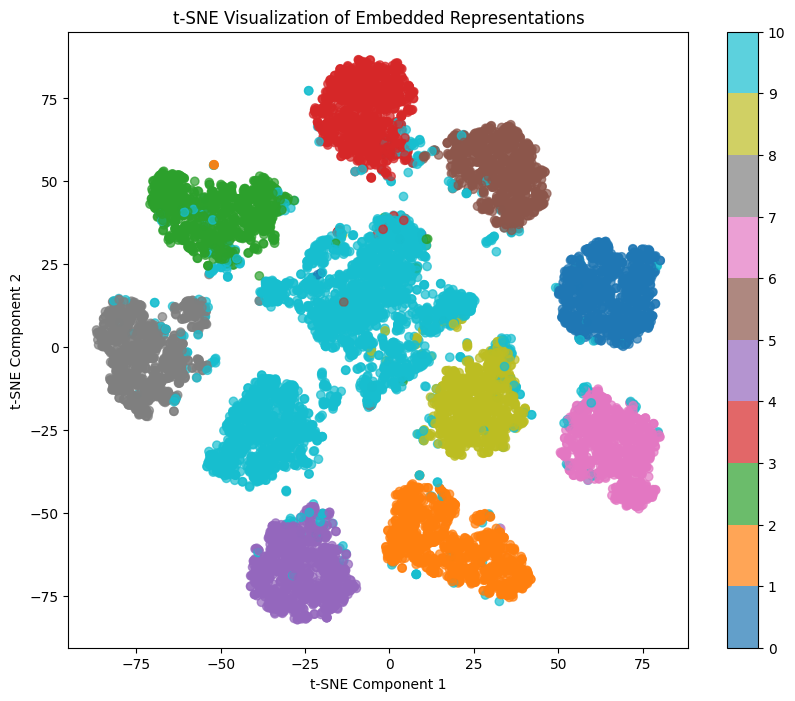

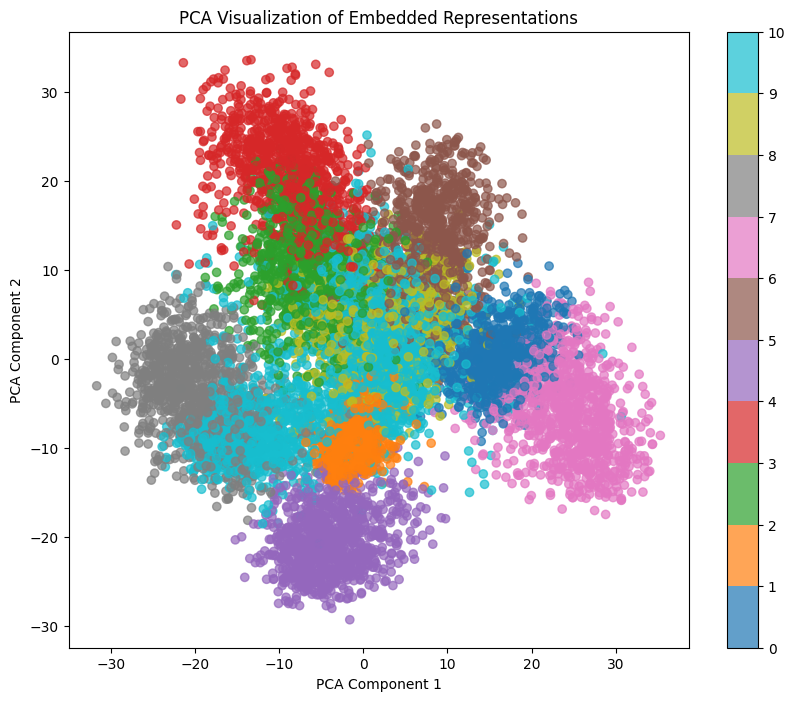

In [29]:
embeddings, predictions = extract_embeddings(OSR_model, data_loader_1, device, threshold=0.975)

plot_tsne(embeddings, predictions)
plot_pca(embeddings, predictions)

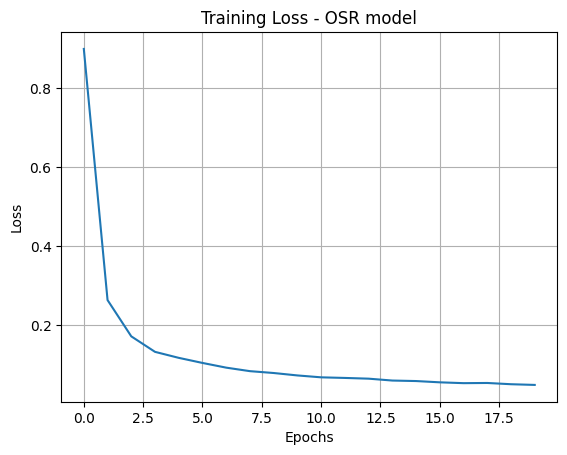

In [30]:
plot_loss(OSR_loss_list, "Training Loss - OSR model")

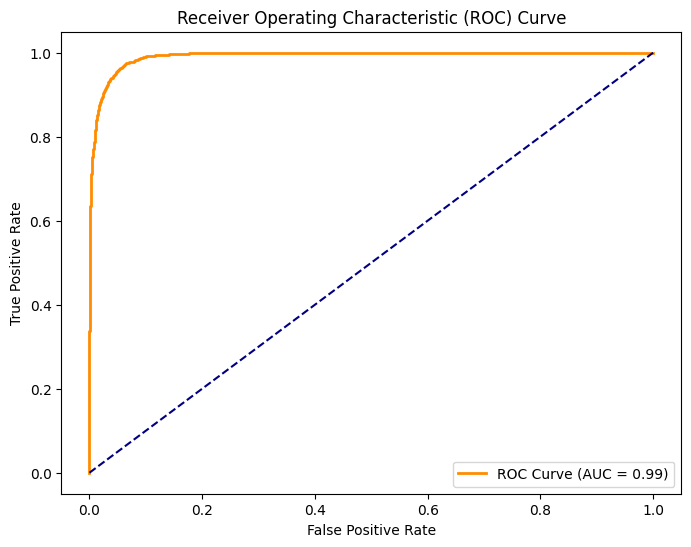

In [31]:
compute_roc(OSR_model, data_loader_1, device)

# Evaluation - Unknown Dataset

In [ ]:
osr_dataset = CombinedDataset(test_dataset, None)
osr_loader = DataLoader(osr_dataset, batch_size=1024, shuffle=True)

In [ ]:
if eval_mode == True:
    OSR_model.load_state_dict(torch.load('./OSR_model.pth'))
    _, acc_ood, _ = eval_model(OSR_model, osr_loader, device, 0.975)
    print(f'OOD Accuracy: {acc_ood*100:.2f}%')

In [ ]:
acc_ood, conf_matrix_ood = evaluate_confusion_matrix(OSR_model, osr_loader, device, 'OOD', 0.975)
print(f'OOD classification accuracy: {acc_ood*100:.2f}%\n')

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ood, annot=True, fmt='d', cmap='Reds', xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for OOD classification')
plt.show()

In [ ]:
acc_total, conf_matrix_osr = evaluate_confusion_matrix(OSR_model, osr_loader, device, 'OSR', 0.975)
print(f'OSR model accuracy: {acc_total*100:.2f}%\n')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_osr, annot=True, fmt='d', cmap='Purples', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for OSR model')
plt.show()